# Tensorflow to Qkeras to Hls4ml


In [1]:
import numpy as np

seed = 0
np.random.seed(seed)

import tensorflow as tf

tf.random.set_seed(seed)


import sys

sys.path.append("/home/webphy/Desktop/dnn_processor/")  # just to enable `dataset`
sys.path.append(
    "/home/webphy/Desktop/dnn_processor/dataset/"
)  # just to enable `dataset`

import dataset
import plotting
import qkeras
import keras

2024-02-03 13:20:05.233813: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-03 13:20:05.257596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 13:20:05.257620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 13:20:05.258444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 13:20:05.262695: I tensorflow/core/platform/cpu_feature_guar

# fetch dataset


In [2]:
BATCH_SIZE = 64
train_images_rgx = "../dataset/resized_dataset_texturas_v2/*/*.jpeg"
valid_images_rgx = "../dataset/resized_dataset_texturas_v2_test/*/*.jpeg"

train_ds, val_ds, nclasses = dataset.create_datasets(
    train_images_rgx, valid_images_rgx, BATCH_SIZE
)

2024-02-03 13:20:06.550413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 13:20:06.574237: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 13:20:06.574389: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# load the model


In [3]:
model_trial_id = 271

model = keras.models.load_model(
    f"../neural_network/automl/saved_models/striped_models/exp6_aug_calib/{model_trial_id}.h5",
    compile=False,
)
model.compile(
    "adam", loss=tf.keras.losses.categorical_crossentropy, metrics=["accuracy"]
)

x = x_in = keras.Input(shape=(256, 256, 3))
x = keras.layers.Activation("linear")(x)
for l in model.layers[1:]:
    x = l(x)


new_model = keras.models.Model(x_in, x)
new_model.compile(
    "adam", loss=tf.keras.losses.categorical_crossentropy, metrics=["accuracy"]
)

score = model.evaluate(val_ds)
score = new_model.evaluate(val_ds)
print("Accuracy: {}".format(score[1]))

2024-02-03 13:20:09.200529: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


1/1 [==============================] - 0s 114ms/step - loss: 0.2439 - accuracy: 0.9400
Accuracy: 0.9399999976158142


# quantize model


In [4]:
from qkeras import *
from keras.layers import Conv2D, DepthwiseConv2D, Activation, Dense, Flatten


def create_qkeras_model_from_keras_model(keras_model):
    x = x_in = keras.Input(shape=keras_model.layers[0].output.shape[1:])

    x = QActivation("quantized_relu(4,0,1)")(x)

    for l in keras_model.layers:
        if isinstance(l, Conv2D):
            qconv2d = QConv2D(
                l.filters,
                l.kernel_size,
                l.strides,
                l.padding,
                kernel_quantizer=quantized_bits(4, 0, 1),
                bias_quantizer=quantized_bits(4, 0, 1),
            )
            x = qconv2d(x)
            qconv2d.set_weights(l.get_weights())

        elif isinstance(l, DepthwiseConv2D):
            qDepthwiseConv2D = QDepthwiseConv2D(
                l.kernel_size,
                l.strides,
                l.padding,
                depthwise_quantizer=quantized_bits(4, 0, 1),
                bias_quantizer=quantized_bits(4, 0, 1),
            )
            x = qDepthwiseConv2D(x)
            qDepthwiseConv2D.set_weights(l.get_weights())

        elif isinstance(l, Activation):
            activation_name = l.get_config()["activation"]
            print(activation_name)
            if activation_name == "tanh":
                x = QActivation(quantized_tanh(4, True))(x)
            elif activation_name == "relu":
                x = QActivation(quantized_relu(4, 0))(x)
            elif activation_name == "linear":
                x = QActivation(quantized_bits(4, 0, 1))(x)
            else:
                print(f"{l.name} was not quantized")

        elif isinstance(l, Flatten):
            # necessary because the layer before Flatten doesnt have avtivation
            x = QActivation(quantized_bits(4, 0, 1, keep_negative=True))(x)
            x = Flatten()(x)

        elif isinstance(l, Dense):
            qdense = QDense(
                l.units,
                kernel_quantizer=quantized_bits(4, 0, 1),
                bias_quantizer=quantized_bits(4, 0, 1),
            )
            x = qdense(x)
            qdense.set_weights(l.get_weights())
        else:
            print(f"{l.name} layer was not quantized...")
    x = Activation("softmax")(x)

    qkeras_model = keras.models.Model(x_in, x)

    return qkeras_model



qkeras_model = create_qkeras_model_from_keras_model(model)
qkeras_model.compile(
    keras.optimizers.Adam(0.0005),
    loss=keras.losses.categorical_crossentropy,
    metrics=["accuracy"],
)
qkeras_model.summary()

input_1 layer was not quantized...
tanh
tanh
relu
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 q_activation (QActivation)  (None, 256, 256, 3)       0         
                                                                 
 q_depthwise_conv2d (QDepth  (None, 85, 85, 3)         30        
 wiseConv2D)                                                     
                                                                 
 q_activation_1 (QActivatio  (None, 85, 85, 3)         0         
 n)                                                              
                                                                 
 q_conv2d (QConv2D)          (None, 41, 41, 24)        1824      
                                                                 
 q_activa

In [5]:
from qkeras.estimate import print_qstats

qkeras_model.evaluate(val_ds)
print_qstats(qkeras_model)

1/1 [==============================] - 1s 1s/step - loss: 0.9573 - accuracy: 0.7400


/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.



Number of operations in model:
    q_conv2d                      : 3025800 (smult_4_4)
    q_conv2d_1                    : 96000 (smult_4_4)
    q_dense                       : 20000 (smult_4_4)
    q_depthwise_conv2d            : 195075 (smult_4_4)
    q_depthwise_conv2d_1          : 38400 (smult_4_4)

Number of operation types in model:
    smult_4_4                     : 3375275

Weight profiling:
    q_conv2d_weights               : 1800  (4-bit unit)
    q_conv2d_bias                  : 24    (4-bit unit)
    q_conv2d_1_weights             : 960   (4-bit unit)
    q_conv2d_1_bias                : 40    (4-bit unit)
    q_dense_weights                : 20000 (4-bit unit)
    q_dense_bias                   : 5     (4-bit unit)
    q_depthwise_conv2d_weights     : 81    (4-bit unit)
    q_depthwise_conv2d_bias        : 3     (4-bit unit)
    q_depthwise_conv2d_1_weights   : 9216  (4-bit unit)
    q_depthwise_conv2d_1_bias      : 24    (4-bit unit)

Weight sparsity:
... quantizing mo

In [6]:
# free memory
del model

# fine tune quantized model


In [7]:
qkeras_model.fit(train_ds, batch_size=64, epochs=5, validation_data=val_ds)

Epoch 1/5


2024-02-03 13:21:06.901750: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model_1/q_activation_3/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-03 13:21:07.257873: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb95ec0e410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-03 13:21:07.257892: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-03 13:21:07.260992: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706977267.316006  104952 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 3s 25ms/step - loss: 0.7248 - accuracy: 0.7937 - val_loss: 0.9573 - val_accuracy: 0.7400
Epoch 2/5
10/10 [==============================] - 0s 25ms/step - loss: 0.6451 - accuracy: 0.8172 - val_loss: 0.6686 - val_accuracy: 0.8400
Epoch 3/5
10/10 [==============================] - 0s 25ms/step - loss: 0.5655 - accuracy: 0.8328 - val_loss: 0.6685 - val_accuracy: 0.8400
Epoch 4/5
10/10 [==============================] - 0s 26ms/step - loss: 0.3463 - accuracy: 0.9031 - val_loss: 0.3593 - val_accuracy: 0.9000
Epoch 5/5
10/10 [==============================] - 0s 26ms/step - loss: 0.2108 - accuracy: 0.9312 - val_loss: 0.3697 - val_accuracy: 0.9000


In [8]:
qkeras_model.save(f"saved_qmodels/{model_trial_id}.h5")

/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)

loaded_qkeras_model = keras.models.load_model(f"saved_qmodels/{model_trial_id}.h5", co)
loaded_qkeras_model.evaluate(val_ds)

# free memory
del loaded_qkeras_model

1/1 [==============================] - 1s 620ms/step - loss: 0.3697 - accuracy: 0.9000


# convert quantized model to HLS4ml


In [10]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(
    qkeras_model,
    granularity="name",
    default_precision="fixed<4,4>",
    default_reuse_factor=2048,
)

config["Model"]["Strategy"] = "Resource"

for layer in config["LayerName"].keys():
    config["LayerName"][layer]["Strategy"] = "Resource"

config["LayerName"]["q_depthwise_conv2d_1"]["Strategy"] = "Latency"

config["LayerName"]["q_dense"]["ReuseFactor"] = 4000
config["LayerName"]["q_dense"]["Strategy"] = "Resource"


plotting.print_dict(config)



/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 256, 256, 3]], output shape: [None, 256, 256, 3]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 256, 256, 3]], output shape: [None, 256, 256, 3]
Layer name: q_depthwise_conv2d, layer type: QDepthwiseConv2D, input shapes: [[None, 256, 256, 3]], output shape: [None, 85, 85, 3]
Layer name: q_activation_1, layer type: HardActivation, input shapes: [[None, 85, 85, 3]], output shape: [None, 85, 85, 3]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 85, 85, 3]], output shape: [None, 41, 41, 24]
Layer name: q_activation_2, layer type: HardActivation, input shapes: [[None, 41, 41, 24]], output shape: [None, 41, 41, 24]
Layer name: q_depthwise_conv2d_1, layer type: QDepthwiseConv2D, input shapes: [[None, 41, 41, 24]], output shape: [None, 10, 10, 24]
Layer name: q_activation_3, layer type: Activation, input shapes: [[None, 10, 10, 24]], output shape: [None, 10

/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [11]:

hls_model = hls4ml.converters.convert_from_keras_model(
    qkeras_model,
    hls_config=config,
    output_dir=f"model_q{model_trial_id}/hls4ml_prj",
    part="xc7z020-clg400-1",
    io_type="io_stream",
)

Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 256, 256, 3]], output shape: [None, 256, 256, 3]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 256, 256, 3]], output shape: [None, 256, 256, 3]
Layer name: q_depthwise_conv2d, layer type: QDepthwiseConv2D, input shapes: [[None, 256, 256, 3]], output shape: [None, 85, 85, 3]
Layer name: q_activation_1, layer type: HardActivation, input shapes: [[None, 85, 85, 3]], output shape: [None, 85, 85, 3]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 85, 85, 3]], output shape: [None, 41, 41, 24]
Layer name: q_activation_2, layer type: HardActivation, input shapes: [[None, 41, 41, 24]], output shape: [None, 41, 41, 24]
Layer name: q_depthwise_conv2d_1, layer type: QDepthwiseConv2D, input shapes: [[None, 41, 41, 24]], output shape: [None, 10, 10, 24]
Layer name: q_activation_3, layer type: Activation, input shapes: [[None, 10, 10, 24]], output shape: [None, 10

/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/hls4ml/backends/fpga/passes/fix_softmax_table_size.py:34: UserWarning: Softmax layer activation_1 table size is too large for inputbitwidth 4. Setting table size to 16.To avoid this warning, please increase input bitwidth ordecrease table size.
  warnings.warn(


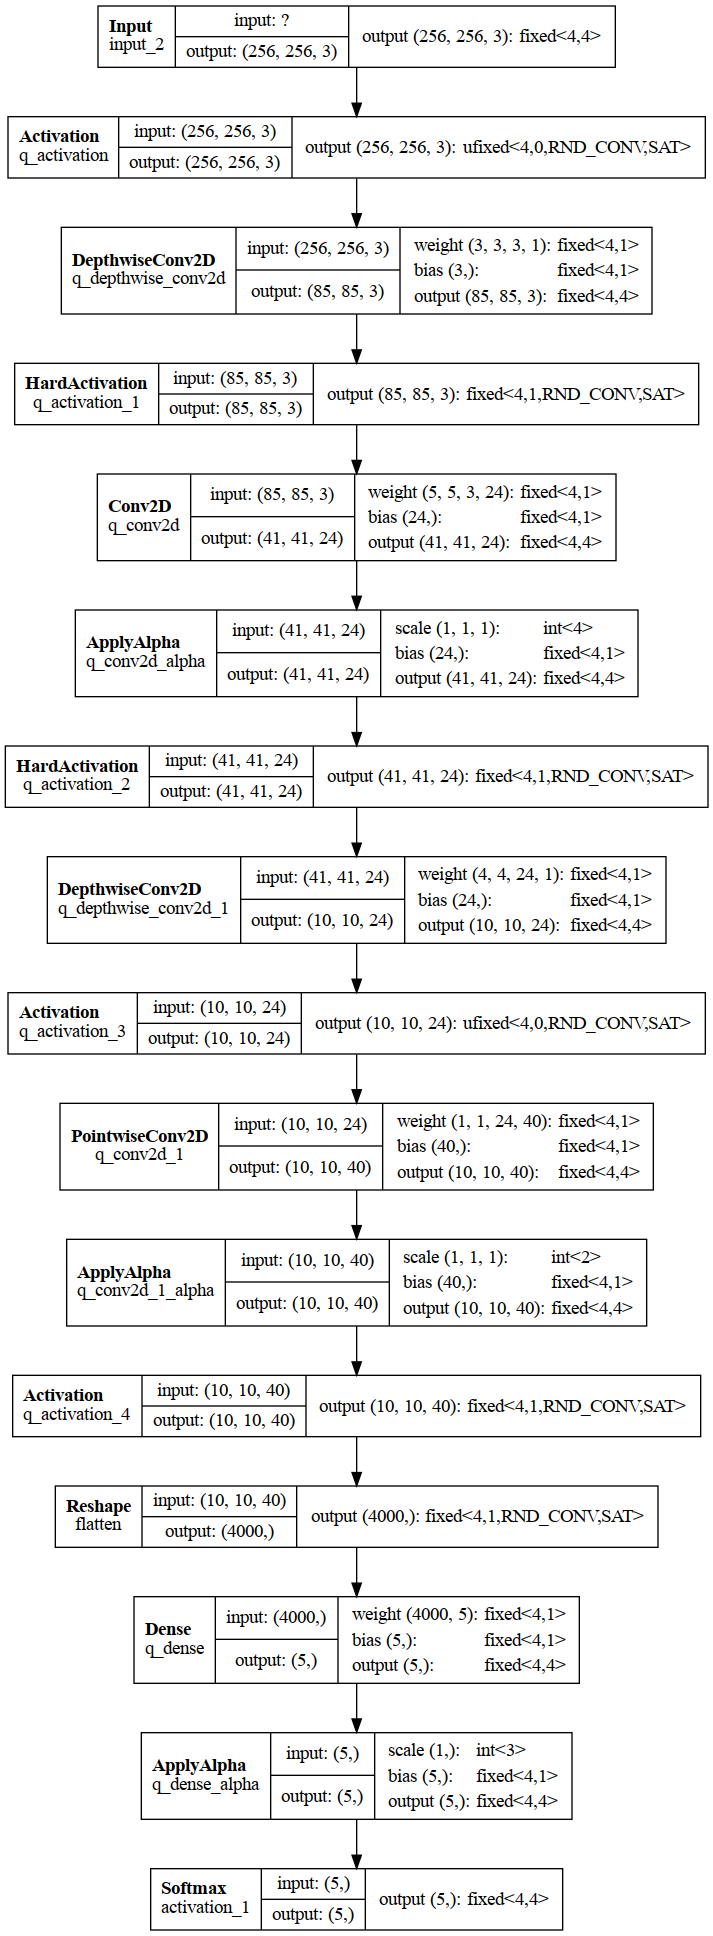

In [12]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [ ]:
hls_model.compile()

In [ ]:
# hls_model.build(csim=False)